# Upper Air Data Plotting with MetPy

In [1]:
# Set up plotting
from IPython.display import display
%matplotlib inline

## Downloading data
We're going to read text data from the University of Wyoming's upper air data archive.

In [2]:
from datetime import datetime
from io import BytesIO, StringIO
from urllib.request import urlopen

# Open the remote URL as a file-like object
dt = datetime(1999, 5, 4, 0)
site = '72357'
url = ('http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST'
       '&YEAR={0.year}&MONTH={0.month:02d}&FROM={0.day:02d}{0.hour:02d}'
       '&TO={0.day:02d}{0.hour:02d}&STNM={1}').format(dt, site)
fobj = urlopen(url)
data = fobj.read()

# Since the archive text format is embedded in HTML, look for the <PRE> tags
data_start = data.find(b'<PRE>')
data_end = data.find(b'</PRE>')

# Wrap the data in a file-like object
text = BytesIO(data[data_start:data_end])

Now we use Numpy's text-file parsing utility:

In [3]:
import numpy as np

p, T, Td, direc, spd = np.genfromtxt(text,
        usecols=(0, 2, 3, 6, 7), skip_header=6, unpack=True)

In [4]:
# Add units to the data arrays
from metpy.units import units

p = p * units.mbar
T = T * units.degC
Td = Td * units.degC
spd = spd * units.knot
direc = direc * units.deg

## Units
So what good do units do?

In [12]:
length = 8 * units.feet
print(length * length)

64 foot ** 2


In [15]:
distance = 10 * units.mile
time = 15 * units.minute
avg_speed = distance / time
print(avg_speed)
print(avg_speed.to_base_units())
print(avg_speed.to('mph'))

0.6666666666666666 mile / minute
17.8816 meter / second
40.0 mph


It also lets us avoid worrying about the exact units of arguments to calculation functions:

In [22]:
from metpy.calc import saturation_vapor_pressure
e = saturation_vapor_pressure(Td)
es = saturation_vapor_pressure(T)
rh = e / es
print(e)
print(es)
print(rh)

[ 21.96006289  19.98584288  19.48647563  19.24092972  19.11917978  16.287494    14.48403518   8.96755291   6.66524756   2.56603242   2.60731565   2.69166378   2.77843701   2.86769586   1.65002064   1.66388656   1.79344929   1.91611139   1.93195973   1.38172212   1.15318043   0.9762567    0.50555742   0.39808199   0.17808618   0.13379062   0.09972985   0.08347382   0.04373764   0.04373764   0.02863351] millibar
[ 26.75264714  23.66068752  23.08140498  21.15073045  20.6258405  19.85995844  19.36336058  17.48439053  17.48439053  17.71012877  16.6065445   14.0153927   11.78735657  10.01442453   7.15972369   6.76164842   4.48224711   2.9363083    2.8005163    1.93195973   1.54276167   1.24661095   0.69357599   0.55540769   0.26299019   0.20173322   0.1553257    0.13094591   0.07126756   0.07046117   0.04751627] millibar
[ 0.8208557   0.84468564  0.84424998  0.90970521  0.92695276  0.82011722  0.74801247  0.51288908  0.38121132  0.14489067  0.15700531  0.19205054  0.23571333  0.28635653  0.2

In [5]:
# Convert wind speed and direction to components
from metpy.calc import get_wind_components
u, v = get_wind_components(spd, direc)

## Plotting on a Skew-T logP

(-40, 60)

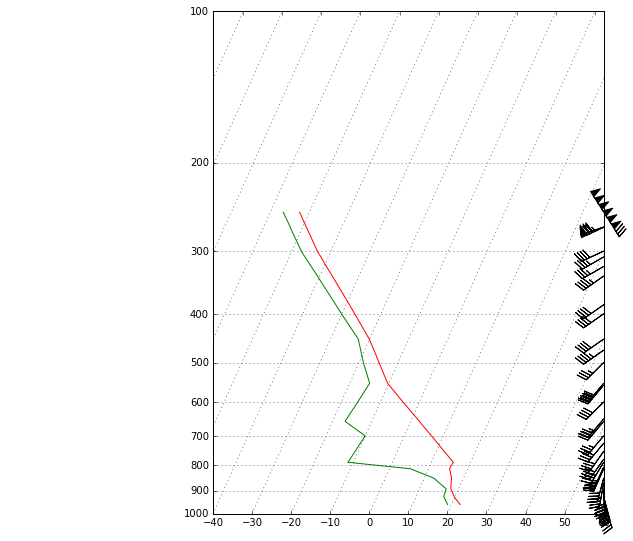

In [6]:
import matplotlib.pyplot as plt
from metpy.plots import SkewT

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(7, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

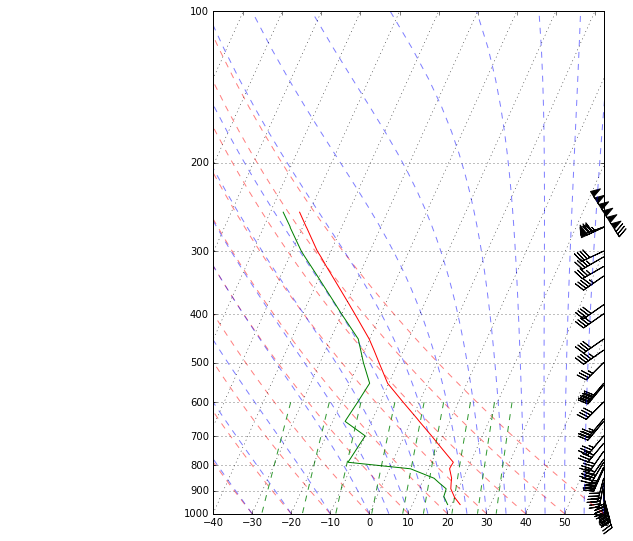

In [7]:
# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
display(fig)

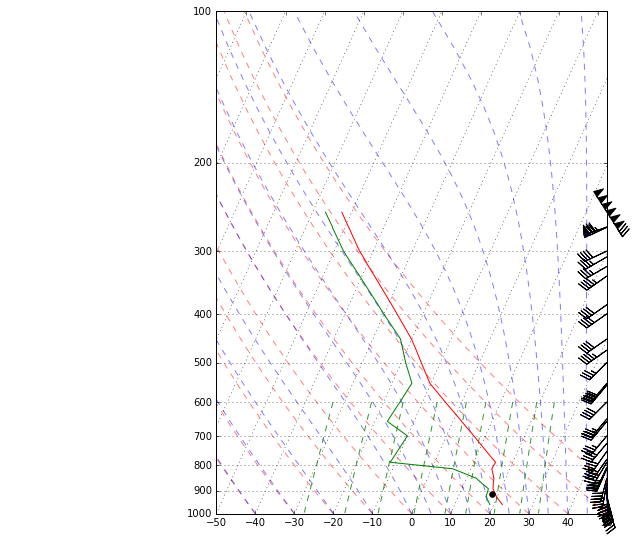

In [8]:
# Calculate LCL height and plot as black dot
from metpy.calc import lcl, dry_lapse
from metpy.units import units, concatenate

l = lcl(p[0], T[0], Td[0])
lcl_temp = dry_lapse(concatenate((p[0], l)), T[0])[-1].to('degC')
skew.plot(l, lcl_temp, 'ko', markerfacecolor='black')
display(fig)

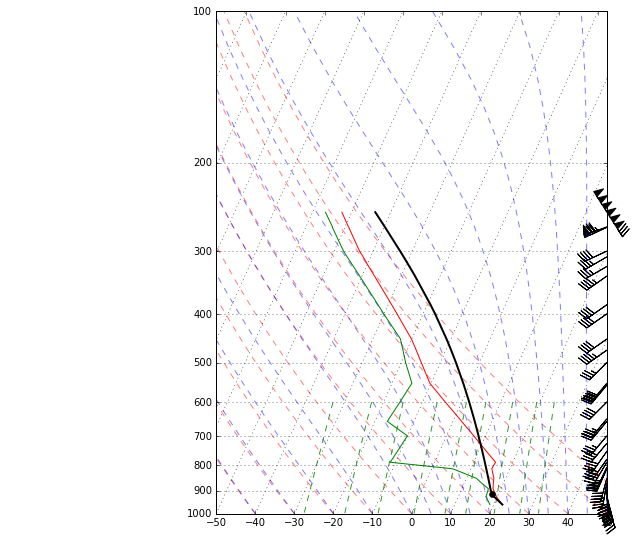

In [9]:
# Calculate full parcel profile and add to plot as black line
from metpy.calc import parcel_profile

prof = parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)
display(fig)

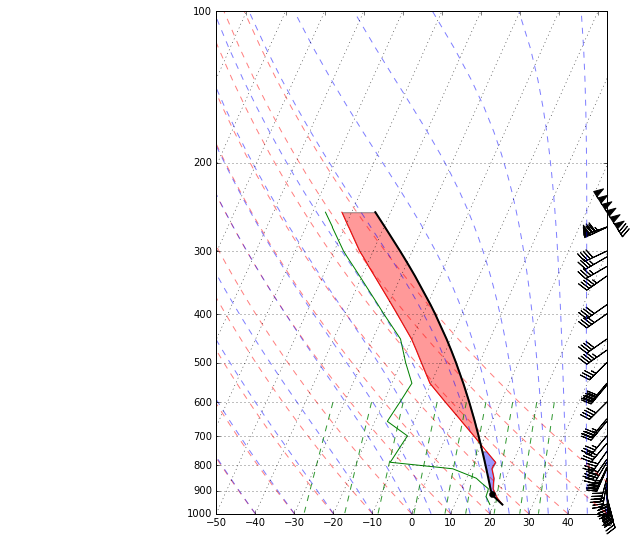

In [10]:
# Example of coloring area between profiles
skew.ax.fill_betweenx(p, T, prof, where=T>=prof, facecolor='blue', alpha=0.4)
skew.ax.fill_betweenx(p, T, prof, where=T<prof, facecolor='red', alpha=0.4)
display(fig)

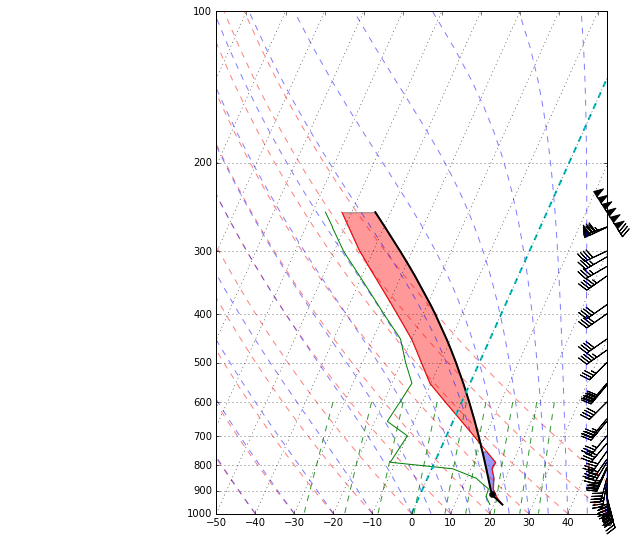

In [11]:
# An example of a slanted line at constant T -- in this case the 0
# isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
display(fig)

### Exercise
Now it's your turn to make a Skew-T.
1. Pick a different date/station and use the code above to download data from a different date
2. Plot the data on a Skew-T
3. Consider adding

   - standard lines
   - highlight specific isotherms (-20C? -40?)
   - Plot LCL and/or parcel profile